Notebook ini merupakan catatan belajar dari artikel medium berikut:

Source: https://utomorezadwi.medium.com/spacy-untuk-training-model-ner-menggunakan-anotasi-bahasa-indonesia-70c900c40d42

# 1. Data Preparation

In [ ]:
# import necessary libraries to get the data
import requests
import html5lib
from bs4 import BeautifulSoup as bs
import pandas as pd

# scrape the text we need
# link = 'https://republika.co.id/berita/qa98w97017000/6-perusahaan-penting-ini-ternyata-milik-sandiaga-uno'
link = 'https://republika.co.id/berita/qcsbt4383/akhlak-sebagai-emcore-valueem-bumn-erick-thohir-bismillah'
req = requests.get(link)
soup = bs(req.content, 'html5lib') #parse html5

# we're only interested in the main text of the web page
paragraphs = soup.findAll('p')

text = []
for p in paragraphs:
    text.append(p.text)
    
# Combining all texts
text_ready = ' '.join(text[5:7])

#Notes: untuk menentukan index dari ' '.join(text[5:7]) perlu dimanual sesuai dengan masing-masing artikel

In [ ]:
print(text_ready)

Menteri BUMN Erick Thohir meluncurkan logo baru Kementerian BUMN di halaman kantor Kementerian BUMN, Jakarta, Rabu (1/7).   REPUBLIKA.CO.ID, JAKARTA -- Menteri Badan Usaha Milik Negara (BUMN) Erick Thohir secara resmi menetapkan akhlak sebagai core value dari BUMN pada Rabu (1/7). Penetapan akhlak sebagai core value BUMN bersamaan dengan acara perubahan logo dan slogan Kementerian BUMN."Hari ini juga saya ingin menetapkan akhlak sebagai core value bukan lip service karena kalau kita bekerja ada core value, ini yang membuat kita kuat," ujar Erick saat meresmikan perubahan logo dan slogan Kementerian BUMN di halaman kantor Kementerian BUMN di Jalan Medan Merdeka Selatan, Jakarta, Rabu (1/7).Erick menjadikan akhlak sebagai panduan bagi manajemen BUMN untuk dapat bekerja dengan benar demi kepentingan bangsa, bukan kepentingan pribadi atau kelompok. Erick memerinci akronim akhlak terdiri atas amanah, kompeten, harmonis, loyal, adaptif, dan kolaboratif.Erick menilai faktor akhlak sangat vita

# 2. Labeling

Kita tertarik untuk men-define label NER sebagai berikut:
- nama
- tanggal
- hari
- lokasi
- organisasi

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# import the function needed for converting from text to dataframe for tagging,
# and the function for converting to spaCy format
# .content.drive.MyDrive.Colab-Notebooks.Summary-NLP.NER.BIOtagging.py
from BIOtagging import text_to_tagReadyDF, convert_to_spaCyformat

In [ ]:
# define annotations used
annotations = sorted(['nama',
               'tanggal',
               'hari',
               'lokasi',
               'organisasi',
               ])

In [ ]:
# convert text to dataframe that is ready for BIO tagging
tagready_df = text_to_tagReadyDF(pd.Series([text_ready]), isCSV=False)
tagready_df.head(20)

1it [00:00, 12.93it/s]

No module named 'Sastrawi' in your machine. Bypassing 'Sastrawi' dependency, but the number of stopwords will decrease.


,token_0,BIO_tag_0
0,Menteri,
1,,O
2,BUMN,
3,,O
4,Erick,
5,,O
6,Thohir,
7,,O
8,meluncurkan,
9,,O


In [ ]:
# save dataframe as a csv file
link_for_save = "text_tagged.csv"
tagready_df.to_csv(link_for_save, index=False)

In [ ]:
#### after manually BIO-tagged in a spreadsheet tool ####

# import BIO-tagged csv file

link_BIOtagged_file = "/content/drive/MyDrive/Colab-Notebooks/Summary-NLP/NER/ner_training_bahasa/text_tagged_done.csv"
df_tagged = pd.read_csv(link_BIOtagged_file)
df_tagged.head(30)

,token_0,BIO_tag_0
0,Menteri,o
1,,O
2,BUMN,b-organisasi
3,,O
4,Erick,b-nama
5,,O
6,Thohir,e-nama
7,,O
8,meluncurkan,o
9,,O


In [ ]:
# convert dataframe to spaCy format that's ready for training
train_data = convert_to_spaCyformat(df_tagged, annotations)
train_data

["Menteri BUMN Erick Thohir meluncurkan logo baru Kementerian BUMN di halaman kantor Kementerian BUMN, Jakarta, Rabu (01-Jul). REPUBLIKA.CO.ID, JAKARTA -- Menteri Badan Usaha Milik Negara (BUMN) Erick Thohir secara resmi menetapkan akhlak sebagai core value dari BUMN pada Rabu (01-Jul). Penetapan akhlak sebagai core value BUMN bersamaan dengan acara perubahan logo dan slogan Kementerian BUMN.``Hari ini juga saya ingin menetapkan akhlak sebagai core value bukan lip service karena kalau kita bekerja ada core value, ini yang membuat kita kuat,'' ujar Erick saat meresmikan perubahan logo dan slogan Kementerian BUMN di halaman kantor Kementerian BUMN di Jalan Medan Merdeka Selatan, Jakarta, Rabu (01-Jul).Erick menjadikan akhlak sebagai panduan bagi manajemen BUMN untuk dapat bekerja dengan benar demi kepentingan bangsa, bukan kepentingan pribadi atau kelompok. Erick memerinci akronim akhlak terdiri atas amanah, kompeten, harmonis, loyal, adaptif, dan kolaboratif.Erick menilai faktor akhlak 

# 3. Training

In [ ]:
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
from spacy.util import decaying
from thinc.neural.optimizers import Adam
import random
from matplotlib import pyplot as plt

def custom_optimizer(optimizer, learn_rate=0.0001, beta1=0.9, beta2=0.999, eps=1e-8, L2=1e-6, max_grad_norm=1.0):
    """
    Function to customizer spaCy default optimizer
    """
    
    optimizer.learn_rate = learn_rate
    optimizer.beta1 = beta1
    optimizer.beta2 = beta2
    optimizer.eps = eps
    optimizer.L2 = L2
    optimizer.max_grad_norm = max_grad_norm
    
    return optimizer

def train_spacy(data, 
                iterations, 
                learn_rate=0.001, 
                beta1=0.9, 
                beta2=0.999, 
                eps=1e-8, #nilai toleransi model 
                L2=1e-4, #rootmeansquare error
                max_grad_norm=1.0):
    """Load the model, set up the pipeline and train the entity recognizer."""
        
    TRAIN_DATA = data
    nlp = spacy.blank('id')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
       

    # add labels
    for _, annotations in TRAIN_DATA:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    
    with nlp.disable_pipes(*other_pipes):  # only train NER
        
        # additional lines
        optimizer = nlp.begin_training(component_cfg={"ner": {"conv_window": 3}})
        optimizer = custom_optimizer(optimizer, learn_rate=learn_rate)
        # Define decaying dropout
#         dropout = decaying(0.8, 0.2, 1e-6)
        
#         optimizer = nlp.begin_training()
        loss_list = []
        for itn in range(iterations):
            print("Starting iteration " + str(itn))
            random.shuffle(TRAIN_DATA)
            losses = {}
            
            # batch up the examples using spaCy's minibatch
            batches = minibatch(TRAIN_DATA, size=compounding(4.0, 64.0, 1.001))
            
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,  # batch of texts
                    annotations,  # batch of annotations
#                     drop=next(dropout),  # dropout - make it harder to memorise data
                    sgd= optimizer,
                    losses=losses)
            
#             for text, annotations in TRAIN_DATA:
#                 nlp.update(
#                     [text],  # batch of texts
#                     [annotations],  # batch of annotations
#                     drop=next(dropout),  # dropout - make it harder to memorise data
#                     sgd=optimizer,  # callable to update weights
#                     losses=losses)

            print(losses)
            loss_list.append(losses)
        
    return nlp, loss_list

In [ ]:
data_dummy = [train_data]
data_dummy

[["Menteri BUMN Erick Thohir meluncurkan logo baru Kementerian BUMN di halaman kantor Kementerian BUMN, Jakarta, Rabu (01-Jul). REPUBLIKA.CO.ID, JAKARTA -- Menteri Badan Usaha Milik Negara (BUMN) Erick Thohir secara resmi menetapkan akhlak sebagai core value dari BUMN pada Rabu (01-Jul). Penetapan akhlak sebagai core value BUMN bersamaan dengan acara perubahan logo dan slogan Kementerian BUMN.``Hari ini juga saya ingin menetapkan akhlak sebagai core value bukan lip service karena kalau kita bekerja ada core value, ini yang membuat kita kuat,'' ujar Erick saat meresmikan perubahan logo dan slogan Kementerian BUMN di halaman kantor Kementerian BUMN di Jalan Medan Merdeka Selatan, Jakarta, Rabu (01-Jul).Erick menjadikan akhlak sebagai panduan bagi manajemen BUMN untuk dapat bekerja dengan benar demi kepentingan bangsa, bukan kepentingan pribadi atau kelompok. Erick memerinci akronim akhlak terdiri atas amanah, kompeten, harmonis, loyal, adaptif, dan kolaboratif.Erick menilai faktor akhlak

In [ ]:
TRAIN_DATA = data_dummy
nlp = spacy.blank('id')  # create blank Language class
# create the built-in pipeline components and add them to the pipeline
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner, last=True)

In [ ]:
# add labels
for _, annotations in TRAIN_DATA:
        for ent in annotations.get('entities'):
            print(ent[2])
            ner.add_label(ent[2])

organisasi
nama
organisasi
organisasi
lokasi
hari
tanggal
lokasi
organisasi
nama
organisasi
hari
tanggal
organisasi
organisasi
nama
organisasi
organisasi
lokasi
hari
tanggal
nama
organisasi
nama
nama
organisasi
organisasi
nama
nama
organisasi
organisasi
organisasi
nama


In [ ]:
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

In [ ]:
other_pipes

[]

In [ ]:
# import the function to train using spaCy
# from train_spacy import train_spacy
# from .content.drive.MyDrive.Colab_Notebooks.Summary_NLP.NER.ner_training_bahasa.train_spacy.py import train_spacy

# training model
model, loss = train_spacy([train_data], 100) # using 100 iterations

Starting iteration 0
{'ner': 266.59092235565186}
Starting iteration 1
{'ner': 245.6228084564209}
Starting iteration 2
{'ner': 259.523118019104}
Starting iteration 3
{'ner': 225.8723156452179}
Starting iteration 4
{'ner': 194.15023493766785}
Starting iteration 5
{'ner': 138.2771002650261}
Starting iteration 6
{'ner': 71.47315385937691}
Starting iteration 7
{'ner': 52.509579775389284}
Starting iteration 8
{'ner': 54.23576935780875}
Starting iteration 9
{'ner': 53.199024672678206}
Starting iteration 10
{'ner': 51.45064263860695}
Starting iteration 11
{'ner': 44.47020742163295}
Starting iteration 12
{'ner': 42.25424429401755}
Starting iteration 13
{'ner': 36.78443960705772}
Starting iteration 14
{'ner': 67.22480887174606}
Starting iteration 15
{'ner': 61.884003748651594}
Starting iteration 16
{'ner': 78.79295921325684}
Starting iteration 17
{'ner': 51.63768498599529}
Starting iteration 18
{'ner': 35.1260281635914}
Starting iteration 19
{'ner': 84.34641799330711}
Starting iteration 20
{'ner

In [ ]:
model

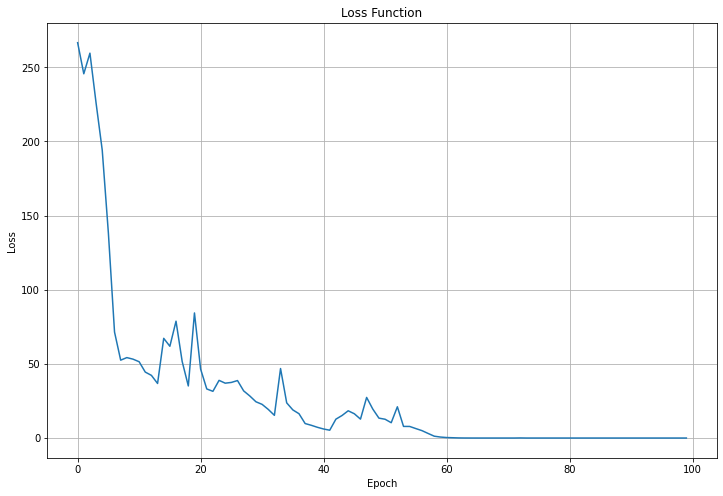

In [ ]:
# we'd like to plot loss
from matplotlib import pyplot as plt

# plotting loss
plt.figure(figsize=(12,8))
plt.plot([i['ner'] for i in loss])
plt.grid()
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Save our trained model
modelfile = input("Enter your Model Name: ")
model.to_disk(modelfile)

Enter your Model Name: model_01


# 4. Evaluation

In [ ]:
# import package for displaying NER results
from spacy import load, displacy

# import model
link_to_model = "/content/drive/MyDrive/Colab_Notebooks/Summary_NLP/NER/ner_training_bahasa/model_01"
loaded_model = load(link_to_model)

# text source: 'https://www.antaranews.com/berita/1584798/erick-tetapkan-akhlak-sebagai-core-value-bumn'
test_text = """Jakarta (ANTARA) - Menteri Badan Usaha Milik Negara (BUMN) Erick Thohir menetapkan Amanah, Kompeten, Harmonis, Loyal, Adaptif, dan Kolaboratif ( AKHLAK)  sebagai "core value" di lingkungan kementerian. "Hari ini, juga saya ingin menetapkan AKHLAK sebagai 'core value', bukan 'lips service', karena kalau kita bekerja ada 'core value' ini yang membuat kita kuat," ujar Menteri Erick di sela sambutan peluncuran logo baru Kementerian BUMN di Kantor Kementerian BUMN, Jakarta, Rabu. Ia mengatakan AKHLAK menjadi nilai-nilai organisasi Kementerian BUMN untuk maju."""

# show the results
doc = loaded_model(test_text)
doc

Jakarta (ANTARA) - Menteri Badan Usaha Milik Negara (BUMN) Erick Thohir menetapkan Amanah, Kompeten, Harmonis, Loyal, Adaptif, dan Kolaboratif ( AKHLAK)  sebagai "core value" di lingkungan kementerian. "Hari ini, juga saya ingin menetapkan AKHLAK sebagai 'core value', bukan 'lips service', karena kalau kita bekerja ada 'core value' ini yang membuat kita kuat," ujar Menteri Erick di sela sambutan peluncuran logo baru Kementerian BUMN di Kantor Kementerian BUMN, Jakarta, Rabu. Ia mengatakan AKHLAK menjadi nilai-nilai organisasi Kementerian BUMN untuk maju.

In [ ]:
colors = {'HARI': '#FF5733',
          'NAMA':'#33C3FF',
          'LOKASI':'#29B64B',
          'ORGANISASI':'#C54AD8'
          }
option = {
    # 'ents': ['HARI'],
    'colors' : colors}

displacy.render(doc, style="ent", jupyter=True, options = option)

In [ ]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Jakarta 0 7 hari
Badan Usaha Milik Negara (BUMN) 27 58 organisasi
Erick Thohir 59 71 nama
Erick 376 381 nama
Kementerian BUMN 420 436 organisasi
Kantor Kementerian 440 458 lokasi
BUMN 459 463 organisasi
Jakarta 465 472 lokasi
Rabu 474 478 hari
Kementerian BUMN 532 548 organisasi


Meskipun masih ada term yang kurang tepat (e.g.`Jakarta --> HARI`), namun sejumlah term sudah dengan tepat dilabeli oleh model NER yang sudah kita train sebelumnya.